In [32]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [33]:
DATA_IN_PATH = '/Users/jeon-yewon/Desktop/데이터 분석 강의/부트캠프/11주차/'
DATA_OUT_PATH = '/Users/jeon-yewon/Desktop/데이터 분석 강의/부트캠프/11주차/'

train_q1_data_file = 'train_q1.npy'
train_q2_data_file = 'train_q2.npy'
train_label_data_file = 'train_label.npy'
data_configs = 'data_configs.json'

In [34]:
tf.random.set_seed(42)

In [35]:
q1_data = np.load(open(DATA_IN_PATH + train_q1_data_file, 'rb'))
q2_data = np.load(open(DATA_IN_PATH + train_q2_data_file, 'rb'))
labels = np.load(open(DATA_IN_PATH + train_label_data_file, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + data_configs, 'r'))

In [36]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [43]:
model_name = 'cnn_similarity'
BATCH_SIZE = 1024
NUM_EPOCHS = 100
VALID_SPLIT = 0.1
MAX_LEN = 31

kargs = {
    'model_name': model_name,
    'vocab_size': prepro_configs['vocab_size'],
    'word_embedding_dimension': 100,
    'conv_num_filters': 300,
    'conv_window_size': 3,
    'max_pool_seq_len': MAX_LEN,
    'sent_embedding_dimension': 128,
    'dropout_rate': 0.2,
    'hidden_dimension': 200,
    'output_dimension': 1
}

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

class SentenceEmbedding(layers.Layer):
    def __init__(self, **kargs):
        super(SentenceEmbedding, self).__init__()

        # 1D 합성곱 레이어
        self.conv = layers.Conv1D(
            filters=kargs['conv_num_filters'], 
            kernel_size=kargs['conv_window_size'], 
            activation='relu', 
            padding='same'
        )
        # 최대 풀링 레이어
        self.max_pool = layers.MaxPool1D(
            pool_size=kargs['max_pool_seq_len'], 
            strides=1
        )
        # 밀집 레이어
        self.dense = layers.Dense(
            units=kargs['sent_embedding_dimension'], 
            activation='relu'
        )

    def call(self, x):
        x = self.conv(x)           # 합성곱 연산
        x = self.max_pool(x)      # 최대 풀링
        x = self.dense(x)         # 밀집 레이어 통과

        return tf.squeeze(x, axis=1)  # 차원 축소

In [45]:
import tensorflow as tf
from tensorflow.keras import layers

class SentenceSimilarityModel(tf.keras.Model):
    def __init__(self, **kargs):
        super(SentenceSimilarityModel, self).__init__(name=kargs['model_name'])

        # 단어 임베딩 레이어
        self.word_embedding = layers.Embedding(
            input_dim=kargs['vocab_size'], 
            output_dim=kargs['word_embedding_dimension']
        )
        
        # 문장 임베딩 레이어 (기본 및 가설)
        self.base_encoder = SentenceEmbedding(**kargs)
        self.hypo_encoder = SentenceEmbedding(**kargs)
        
        # 드롭아웃 레이어
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        
        # 밀집 레이어
        self.dense = layers.Dense(kargs['hidden_dimension'], activation='relu')
        
        # 최종 로짓 레이어
        self.logit = layers.Dense(1, activation='sigmoid')

    def call(self, x):
        x1, x2 = x  # 두 문장을 입력으로 받음
        b_x = self.word_embedding(x1)  # 첫 번째 문장 임베딩
        h_x = self.word_embedding(x2)  # 두 번째 문장 임베딩

        # 드롭아웃 적용
        b_x = self.dropout(b_x)
        h_x = self.dropout(h_x)

        # 문장 임베딩 통과
        b_x = self.base_encoder(b_x)
        h_x = self.hypo_encoder(h_x)

        # 두 문장 임베딩 결합
        e_x = tf.concat([b_x, h_x], -1)
        
        # 밀집 레이어 통과
        e_x = self.dense(e_x)
        e_x = self.dropout(e_x)

        # 최종 출력
        return self.logit(e_x)

In [46]:
model = SentenceSimilarityModel(**kargs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='acc')]
)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

mc = ModelCheckpoint('best_model', 
                     monitor='val_acc', 
                     mode='max', 
                     verbose=1, 
                     save_best_only=True, 
                     save_format='tf')

In [54]:
history = model.fit(
    (q1_data, q2_data), 
    labels, 
    batch_size=BATCH_SIZE, 
    epochs=NUM_EPOCHS, 
    validation_split=VALID_SPLIT, 
    callbacks=[es, mc]
)

Epoch 1/100
263/263 [==============================] - ETA: 0s - loss: 0.2801 - acc: 0.8773
Epoch 1: val_acc improved from -inf to 0.77168, saving model to best_model


2024-07-12 13:29:32.340213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,31,100]
	 [[{{node inputs}}]]
2024-07-12 13:29:32.356312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200]
	 [[{{node inputs}}]]
2024-07-12 13:29:32.715667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,31,100]
	 [[{{node inputs}}]]
2024-07-12

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


263/263 [==============================] - 182s 691ms/step - loss: 0.2801 - acc: 0.8773 - val_loss: 0.5852 - val_acc: 0.7717
Epoch 2/100
263/263 [==============================] - ETA: 0s - loss: 0.2459 - acc: 0.8938
Epoch 2: val_acc improved from 0.77168 to 0.83941, saving model to best_model


2024-07-12 13:33:06.669849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,31,100]
	 [[{{node inputs}}]]
2024-07-12 13:33:06.703571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,200]
	 [[{{node inputs}}]]
2024-07-12 13:33:07.356260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,31,100]
	 [[{{node inputs}}]]
2024-07-12

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


263/263 [==============================] - 215s 820ms/step - loss: 0.2459 - acc: 0.8938 - val_loss: 0.4538 - val_acc: 0.8394
Epoch 3/100
263/263 [==============================] - ETA: 0s - loss: 0.1943 - acc: 0.9179
Epoch 3: val_acc did not improve from 0.83941
263/263 [==============================] - 197s 746ms/step - loss: 0.1943 - acc: 0.9179 - val_loss: 0.5427 - val_acc: 0.8318
Epoch 4/100
263/263 [==============================] - ETA: 0s - loss: 0.1633 - acc: 0.9323
Epoch 4: val_acc did not improve from 0.83941
263/263 [==============================] - 234s 889ms/step - loss: 0.1633 - acc: 0.9323 - val_loss: 0.7202 - val_acc: 0.7875
Epoch 5/100
263/263 [==============================] - ETA: 0s - loss: 0.1430 - acc: 0.9411
Epoch 5: val_acc did not improve from 0.83941
263/263 [==============================] - 206s 785ms/step - loss: 0.1430 - acc: 0.9411 - val_loss: 0.7139 - val_acc: 0.8106
Epoch 6/100
263/263 [==============================] - ETA: 0s - loss: 0.1288 - acc: 0

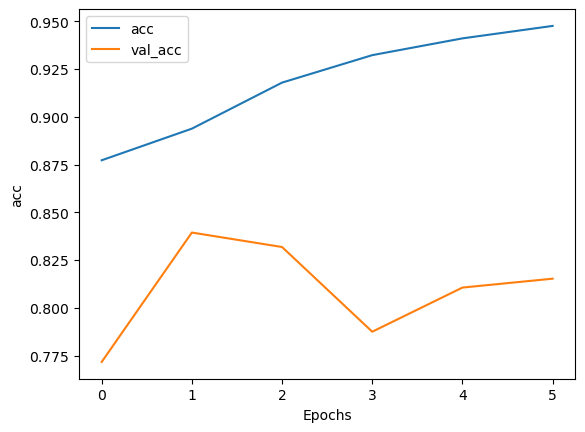

In [55]:
plot_graphs(history, 'acc')

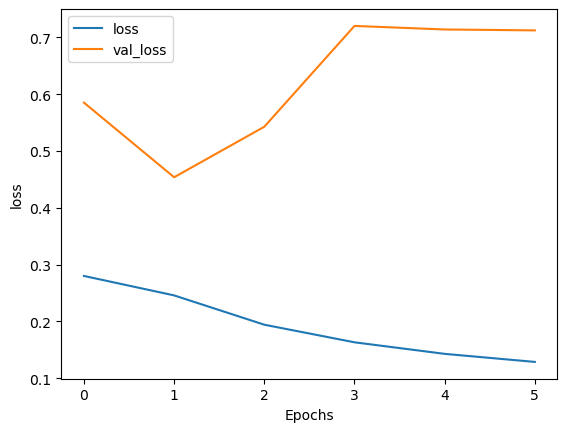

In [57]:
plot_graphs(history, 'loss')

In [ ]:
# test data

In [58]:
test_q1_data_file = 'test_q1.npy'
test_q2_data_file = 'test_q2.npy'
test_id_data_file = 'test_id.npy'

test_q1_data = np.load(open(DATA_IN_PATH + test_q1_data_file, 'rb'))
test_q2_data = np.load(open(DATA_IN_PATH + test_q2_data_file, 'rb'))
test_id_data = np.load(open(DATA_IN_PATH + test_id_data_file, 'rb'), allow_pickle=True)

In [59]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

2048/2048 [==============================] - 422s 206ms/step


In [60]:
print(predictions)

[[4.5176722e-02]
 [2.0772465e-01]
 [5.3563440e-01]
 ...
 [2.8024115e-06]
 [1.7391229e-01]
 [6.7315256e-07]]


In [61]:
print(predictions.squeeze(-1))

[4.5176722e-02 2.0772465e-01 5.3563440e-01 ... 2.8024115e-06 1.7391229e-01
 6.7315256e-07]


In [62]:
model_name = 'manlstm_similarity'

kargs['model_name'] = model_name
kargs['lstm_dimension'] = 150

kargs

{'model_name': 'manlstm_similarity',
 'vocab_size': 76672,
 'word_embedding_dimension': 100,
 'conv_num_filters': 300,
 'conv_window_size': 3,
 'max_pool_seq_len': 31,
 'sent_embedding_dimension': 128,
 'dropout_rate': 0.2,
 'hidden_dimension': 200,
 'output_dimension': 1,
 'lstm_dimension': 150}

In [69]:
class ManLSTM(tf.keras.Model):
    def __init__(self, **kargs):
        super(ManLSTM, self).__init__(name=model_name)

        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['word_embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])

    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)

        # 두 시퀸스에 대한 LSTM 출력 정보의 차이를 계산(obs(x1-x2))
        # 차이 벡터의 요소들을 합산하여 Manhotton 거리를 계산(reduce_sum)
        # 지수 함수를 통해 거리를 유사도로 변환(exp(-x))
        return tf.exp(-tf.reduce_sum(tf.abs(x1 - x2), axis=1))

In [70]:
model = ManLSTM(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss=tf.keras.losses.BinaryCrossentropy(), metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [ ]:
history = model.fit((q1_data, q2_data), labels, batch_size=128, epochs=5, validation_split=VALID_SPLIT, callbacks=[es, mc])

Epoch 1/5


2024-07-12 14:46:31.778626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-12 14:46:31.779697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-12 14:46:31.780332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2099/2100 [============================>.] - ETA: 0s - loss: 0.5290 - accuracy: 0.7377

2024-07-12 14:52:31.250063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-12 14:52:31.250765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-12 14:52:31.251916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2100/2100 [==============================] - 367s 174ms/step - loss: 0.5290 - accuracy: 0.7377 - val_loss: 0.5030 - val_accuracy: 0.7725
Epoch 2/5
2099/2100 [============================>.] - ETA: 0s - loss: 0.4033 - accuracy: 0.8201WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2100/2100 [==============================] - 274s 130ms/step - loss: 0.4033 - accuracy: 0.8201 - val_loss: 0.3595 - val_accuracy: 0.8717
Epoch 3/5
2100/2100 [==============================] - ETA: 0s - loss: 0.3618 - accuracy: 0.8423WARNING:tensorflow:Can save best model only with val_acc available, skipping.


2100/2100 [==============================] - 363s 173ms/step - loss: 0.3618 - accuracy: 0.8423 - val_loss: 0.7712 - val_accuracy: 0.6342
Epoch 4/5
 280/2100 [===>..........................] - ETA: 9:46 - loss: 0.3303 - accuracy: 0.8611

In [ ]:
plot_graphs(history, 'acc')

In [ ]:
plt_graphs(history, 'loss')

In [ ]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=128)

In [ ]:
print(predictions)